### This phase of the development notebook is mostly to figure out the TBC code, and refine the video RF decoding code.

In [1]:
# Just your usual setup

import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 
import matplotlib.pyplot as plt
import sys
import getopt

%matplotlib inline

import matplotlib
matplotlib.rc('figure', figsize=(20, 12))

from datetime import  datetime

import fft8 as fft8 
import ld_utils as utils

import copy

# for image display
from PIL import Image
from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode

In [2]:
pi = np.pi
tau = np.pi * 2

# Optimal if this is a power of 2
blocklenk = 16
blocklen = (blocklenk * 1024)
# may need to adjust this depending on block length
blockcut = 512

In [3]:
# charting/graphing code carried over from earlier development efforts

def dosplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    db = 20 * np.log10(abs(h))

    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print("-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -10) and (db[i - 1] >= -10):
            print("<-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -20) and (db[i - 1] >= -20):
            print("<-20db crossing at ", w[i] * (freq/pi) / 2.0) 

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    plt.show()

def doplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    db = 20 * np.log10(abs(h))
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 

    ax1 = fig.add_subplot(111)

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# plot two filters (haven't tested in a long while!)
def doplot2(B, A, B2, A2, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)
    w2, h2 = sps.freqz(B2, A2)

    begin = 0
    end = len(w)
    chop = 0

    w = w[begin:end]
    w2 = w2[begin:end]
    h = h[begin:end]
    h2 = h2[begin:end]

    v = np.empty(len(w))

    hm = np.absolute(h)
    hm2 = np.absolute(h2)

    v0 = hm[0] / hm2[0]
    for i in range(0, len(w)):
        v[i] = (hm[i] / hm2[i]) / v0

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    v  = 20 * np.log10(v )

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'r')
    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h2)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    angles2 = np.unwrap(np.angle(h2))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.plot(w * (freq/pi) / 2.0, angles2, 'y')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# This matches FDLS-based conversion surprisingly well (i.e. FDLS is more accurate than I thought ;) )
def BA_to_FFT(B, A, blocklen):
    return np.complex64(sps.freqz(B, A, blocklen, whole=True)[1])

# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [4]:
# System default specs for NTSC and PAL.

NTSC_hz_ire = (9300000 - 7600000) / 140.0 # Later disks may have a higher white point

SysParams_NTSC = {
    'system_name': 'NTSC',
    
    'audio_lfreq': 2301136,
    'audio_rfreq': 2812499,

    'analog_audio': True,

    'fsc_mhz': (315.0 / 88.0),
    'line_period': 63.5, # in usecs

    # video frequencies 
    # per spec, range from -40 to 100 IRE is 1.7mhz, so 12142 ire/mhz
    'hz_ire': NTSC_hz_ire,
    
    'videorf_sync'  : 8100000-(NTSC_hz_ire * -40),
    'videorf_0ire'  : 8100000,
    'videorf_7.5ire': 8100000+(NTSC_hz_ire*7.5),
    'videorf_100ire': 8100000+(NTSC_hz_ire*100), # NOTE: slightly higher on later disks

    # IRE range is actually -40 to 110, but leave some margin here and match 0-65534 scaling
    'ire_min': -60,
    'ire_max': 140,

    # tunable parameters.  These work well with DD 2_2 + eliptical filter, which is a bit more
    # picky about audio RF filtering.
    
    #'deemp': (120, 320), # actual deemp timing... at least the usec #'s.
    'deemp': (120*.7, 320*.7), # On some captures this is as low as .55.

    # The audio notch filters didn't work right until the ellipcital filter was implemented...
    'audio_filtwidth': 150000,
    'audio_filtorder': 2,

    # similar but not identical to what Pioneer did
    'vbpf': (3500000, 13200000),
    'vbpf_order': 3,
    
    # This can easily be pushed up to 4.5mhz...
    'vlpf_freq': 4200000,   # in mhz
    'vlpf_order': 5 # butterworth filter order
    
}

SysParams_PAL = {
    # System parameters
    'system_name': 'PAL',

    'fsc_mhz': 4.43361875,
    'line_period': 64, # in usecs
    
    'audio_lfreq': 683593,
    'audio_rfreq': 1066400,

    # video frequencies 
    'videorf_sync': 6760000, # on LD this includes a very strong pilot signal
    'videorf_0ire': 7100000,
    'videorf_100ire': 7900000,

    'ire_min': -95, # needed for pilot signal
    'ire_max': 145,

    # changeable defaults
    'analog_audio': False, # not true for later PAL

    'deemp': (100, 400),

    # XXX: guessing here!
    'vbpf': (2600000, 11000000),
    'vbpf_order': 3,
    'vlpf_freq': 4800000,	# in mhz
    'vlpf_order': 5,		# butterworth filter order

    'audio_filtwidth': 200000,
    'audio_filtorder': 1,
}

# support reloading/rerunning from ipython
try:
    # a dummy load
    tmp = SysParams['fsc_mhz']
except:
    SysParams = copy.deepcopy(SysParams_NTSC)
    

In [5]:
params = {'freq': 40}

for p in [SysParams_NTSC]:
    for k in p.keys():
        print(k, p[k])
        params[k] = p[k]

system_name NTSC
audio_lfreq 2301136
audio_rfreq 2812499
analog_audio True
fsc_mhz 3.5795454545454546
line_period 63.5
hz_ire 12142.857142857143
videorf_sync 8585714.285714285
videorf_0ire 8100000
videorf_7.5ire 8191071.428571428
videorf_100ire 9314285.714285715
ire_min -60
ire_max 140
deemp (84.0, 224.0)
audio_filtwidth 150000
audio_filtorder 2
vbpf (3500000, 13200000)
vbpf_order 3
vlpf_freq 4200000
vlpf_order 5


In [6]:
def inrange(a, mi, ma):
    return (a >= mi) & (a <= ma)

def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

In [7]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*200+[0]*200)
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do the 'heavy lifting'
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

def filtfft(filt, blen = blocklen):
    return sps.freqz(filt[0], filt[1], blen, whole=1)[1]

Decoding notes:

- My RF decoder is based off frequency-domain transforms.  This allows multiple filters to be applied in one operation, and multiple different filters can also be applied, which will come into play when working on audio

In [8]:
# A rather pants attempt at doing an MTF function, but it seems to work well...
[tf_b, tf_a] = sps.zpk2tf(.1, -.5, 1.0)
Fmtf = filtfft([tf_b, tf_a])

# This prepares the needed transforms to do the actual video decoding
def prepare_video_filters(params):
    SP = copy.deepcopy(params)
    
    SP['freq_hz'] = SP['freq'] * 1000000.0
    SP['line_px'] = SP['freq_hz'] * (SP['line_period'] / 1000000.0)
        
    freq_hz = SP['freq_hz']
    freq_hz_half = SP['freq_hz'] / 2
    freq_half = SP['freq'] / 2

    # RF BPF and analog audio cut filters
    SP['FRFVideo'] = filtfft(sps.butter(SP['vbpf_order'], [SP['vbpf'][0]/freq_hz_half, SP['vbpf'][1]/freq_hz_half], btype='bandpass'))
    
    # If there is analog audio, it must be filtered well especially with DD >=2.2 RF captures
    if SP['analog_audio'] and SP['audio_filtorder']: 
        SP['Fcutl'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_lfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_lfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        SP['Fcutr'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_rfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_rfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        
        SP['FRFVideo'] *= (SP['Fcutl'] * SP['Fcutr'])
    
    # standard post-demod LPF
    SP['Fvideo_lpf'] = filtfft(sps.butter(SP['vlpf_order'], SP['vlpf_freq']/freq_hz_half, 'low')) # standard 4.Xmhz

    # post-demodulation deemphasis filter
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10)/2.0, -SP['deemp'][0]*(10**-10)/2.0, SP['deemp'][0] / SP['deemp'][1])
    SP['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half))

    # Post processing:  lowpass filter + deemp
    SP['FVideo'] = SP['Fvideo_lpf'] * SP['Fdeemp'] 
    
    # additional filters:  0.5mhz and color burst
    SP['F0_5'] = filtfft(sps.butter(1, 0.5/freq_half, 'low')) 
    SP['FVideo05'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['F0_5']

    if SP['system_name'] == 'NTSC':
        SP['Fcburst'] = filtfft(sps.butter(1, [(SP['fsc_mhz'] * .95)/freq_half, (SP['fsc_mhz'] * 1.05)/freq_half], btype='bandpass')) 
    else:
        SP['Fcburst'] = filtfft(sps.butter(1, [3.7/freq_half, 3.8/freq_half], btype='bandpass')) 
        
    SP['FVideoBurst'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['Fcburst']
    
    # emperical work determined that a single-pole low frequency filter effectively 
    # detects the end of a (regular) sync pulse when binary level detection is used. TODO: test with PAL
    f = sps.butter(1, 0.05/(params['freq'] / 2.0), btype='low')
    SP['FPsync'] = filtfft(f)
    
    return SP

In [9]:
# The actual video demodulation code

def dodemod(paramsc, data, clip = None, usemtf = False, cutarf = False):
    indata_fft = np.fft.fft(data)
    indata_fft_filt = indata_fft * paramsc['FRFVideo']

    if usemtf:
        indata_fft_filt *= Fmtf

    hilbert = np.fft.ifft(indata_fft_filt * fft_hilbert)

    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
        dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    # With extremely bad data, the unwrapped angles can jump.
    while np.min(tdangles2) < 0:
        tdangles2[tdangles2 < 0] += tau
    while np.max(tdangles2) > tau:
        tdangles2[tdangles2 > tau] -= tau
    demod = (tdangles2 * (paramsc['freq_hz'] / tau))

    demod_fft = np.fft.fft(demod)
    
    out_video = np.fft.ifft(demod_fft * paramsc['FVideo']).real
    out_video05 = np.fft.ifft(demod_fft * paramsc['FVideo05']).real
    out_videoburst = np.fft.ifft(demod_fft * paramsc['FVideoBurst']).real
    
    # NTSC: filtering for vsync pulses from -55 to -25ire seems to work well even on rotted disks
    output_sync = (out_video > (params['videorf_0ire'] + (params['hz_ire'] * -55))) & (out_video < (params['videorf_0ire'] + (params['hz_ire'] * -25)))
    # Perform FFT convolution of above filter
    output_syncf = np.fft.ifft(np.fft.fft(output_sync) * filterset['FPsync']).real
    
    return np.rec.array([out_video, out_video05, output_syncf, out_videoburst], names=['demod', 'demod_05', 'demod_sync', 'demod_burst'])
    #return out_video, out_video05, out_videoburst

In [10]:
def lineplot(output, param):
    plt.plot(output)
    
    if param['system_name'] == 'PAL':
        plt.axhline(7100000, color='black') # black
        plt.axhline(7900000, color='black') # white

        # burst
        plt.axhline(7100000 - (800000 * 1.5 / 7), color='g')
        plt.axhline(7100000 + (800000 * 1.5 / 7), color='g')

        # pilot low (pilot high is 7.1mhz)
        plt.axhline((7900000-(800000/.7))-(800000*(3/7)), color='b')
    else: # NTSC
        
        plt.axhline(params['videorf_0ire'], color='black') # 0IRE
        plt.axhline(params['videorf_7.5ire'], color='black') # black for most disks
        plt.axhline(params['videorf_100ire'], color='black') # white

        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 80), color='blue')
        
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 20), color='green')
        plt.axhline(params['videorf_0ire'] - (params['hz_ire'] * 20), color='green')
        
        # sync
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * -40), color='blue')

In [11]:
def calcsnr(a):
    stdire = np.std(a) / NTSC_hz_ire
    return(20 * np.log10(100 / stdire))

In [12]:
# old lddecode format for hz->uint16 conversion
minire = -60
maxire = 140
hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

In [252]:
def demod(infile, _start, _end, filterset):
    infile_len = infile.seek(0, 2)
    
    if _end > infile_len:
        end = infile_len
    else:
        end = _end
    
    if (_start > blockcut):
        start = _start - blockcut
    else:
        start = 0 # should this be an error?  prolly.

    print(start, end, (end - start))
    
    # set a placeholder
    output = None #np.zeros(end - start + 1, dtype=('double, double, double'))
        
    for i in range(start, end, blocklen - blockcut):
        #print(i, start, end)
        infile.seek(i * sampletype, 0)
        inbuf = infile.read(blocklen * sampletype)
        
        if sampletype == 2:
            indata = np.fromstring(inbuf, 'int16', len(inbuf) // 2)
        else:
            indata = np.fromstring(inbuf, 'uint8', len(inbuf))
    
        if len(indata) < blocklen:
            print('b', len(indata), blocklen )
            break
    
        tmp = dodemod(filterset, indata, usemtf=True)
        
        # if the output hasn't been created yet, do it now using the 
        # data types returned by dodemod (should be faster than multiple
        # allocations...)
        if output is None:
            output = np.zeros(end - start + 1, dtype=tmp.dtype)
        
        if i - start + (blocklen - blockcut) > len(output):
            copylen = len(output) - (i - start)
        else:
            copylen = blocklen - blockcut

        output_slice = slice(i - start, i - start + copylen)
        tmp_slice = slice(blockcut, blockcut + copylen)
            
        output[output_slice] = tmp[tmp_slice]

    #print(output.shape)
    return output

In [253]:
if True: # DD 3.0 beta fantasia example
    params['freq'] = 40.0
    deemp_adj1 = .65
    deemp_adj2 = .65
    params['deemp'] = (120*deemp_adj1, 320*deemp_adj2)
    sampletype = 2

    params['vbpf'] = (3500000, 13500000)
    params['vbpf_order'] = 2

    params['vlpf_freq'] = 4200000
    params['vlpf_order'] = 5

else: # cxadc capture
    params['freq'] = 8 * 315 / 88
    sampletype = 1

    deemp_adj = 1
    params['deemp'] = (140*deemp_adj, 320*deemp_adj)
    
    params['vbpf'] = (3500000, 13500000)
    params['vbpf_order'] = 3

    params['vlpf_freq'] = 4200000
    params['vlpf_order'] = 3

filterset = prepare_video_filters(params)

#infile = open('/home/cpage/ldcaps/ggv1069-22000.raw', 'rb')
infile = open('ggv_22k.raw', 'rb')
#tmp= demod(infile, 50000, 2000000, filterset)

In [256]:
import time

t1 = time.time()
tmp= demod(infile, 1100000, 2000000, filterset)
time.time() - t1

1099488 2000000 900512


0.3620874881744385

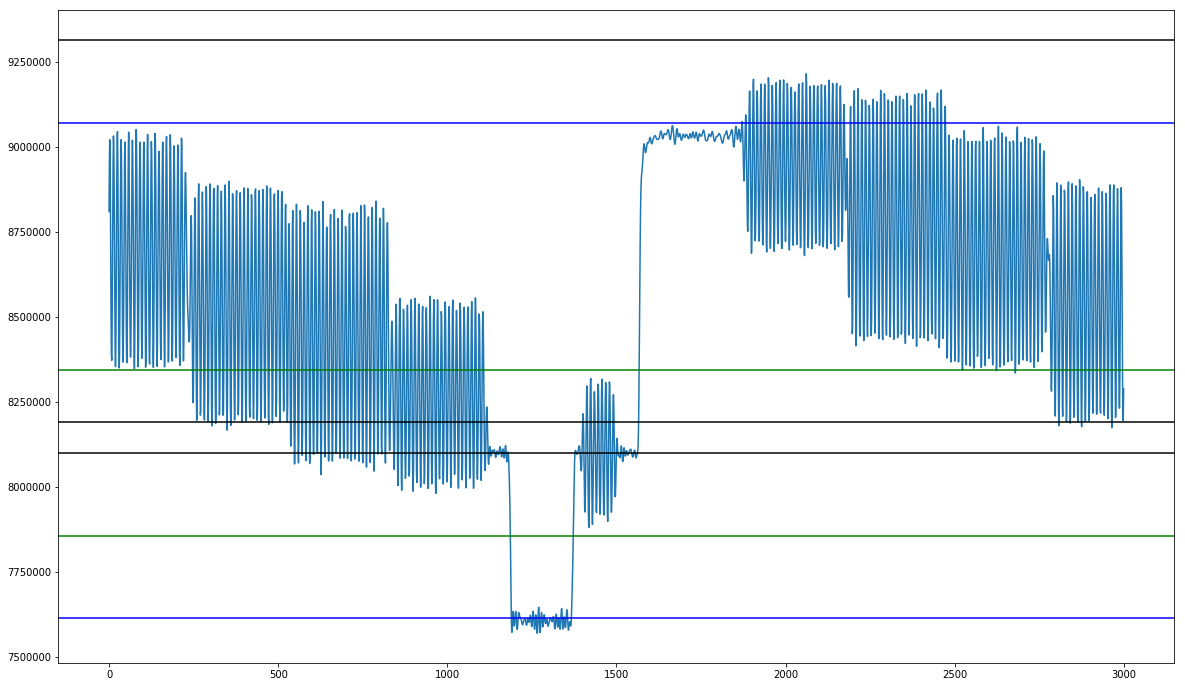

In [257]:
lineplot(tmp['demod'][595000:598000], filterset)


Below this is the less developed code to deal with NTSC framing and syncs.

A plot of output_syncf here shows a nice pattern overall:

- Vsyncs reach 1.0 (and the mininum in those areas is ~0.23)
- regular hsyncs come in about 0.77 (the glitches are where the LD player "rewinds" for still frames)
- equalization pulses come in about 0.5

In [259]:
output = tmp['demod']
output_sync = tmp['demod_sync']
output_lp = tmp['demod_05']

In [266]:
def findburstfromsync(syncf, center):
    ilinepx = int(filterset['line_px'])

    if syncf[center] < .2:
        print('invalid location')
    try:
        scanarea = (ilinepx * 6)
        threshold = .15

        startsync = center - scanarea + np.where(syncf[center - scanarea:center] < threshold)[0][-1]
        # note: endsync usually includes the first equalization pulse
        endsync = center + np.where(syncf[center:center + scanarea] < threshold)[0][0]
    except:
        print('oh oh, sync ends not found')
        return None

    try:
        lastlinepresync = (startsync - (ilinepx * 4)) + np.where(syncf[startsync - (ilinepx * 4): startsync] > .55)[0][-1]
        # compute equalization length with .08 compensation factor
        presync_eqlen = ((startsync - lastlinepresync) / ilinepx) + .08
    except:
        print("error: couldn't find prev line")
        lastlinepresync = None
        presync_eqlen = None

    try:
        nextline = endsync + np.where(syncf[endsync: endsync + (ilinepx * 4)] > .55)[0][0]
        # the offset is larger here since the first equalization pulse is close enough to the end of vsync
        postsync_eqlen = ((nextline - endsync) / ilinepx) + .56
    except:
        print("error: couldn't find next line")
        nextline = None
        postsync_eqlen = None

    return (lastlinepresync, nextline, presync_eqlen, postsync_eqlen)



In [327]:
def findsync(output_sync, loc = 0):
    loc = 0
#    imglen = (int)((filterset['freq_hz'] / 59.976) * 1.25)

#    if (loc + imglen) > len(output_sync):
#        print("get more data")

    # find the next sync point.  should be > .9
    syncloc = np.argmax(output_sync[loc:loc+imglen]) + loc

    if np.max(output_sync[loc:loc+imglen]) < .9:
        #print("oops.  can't find a good sync")
        return (None, None)

    print(np.max(output_sync[loc:loc+imglen]))
    
    rv = findburstfromsync(output_sync, syncloc)
    if rv is None:
        return None, None, None
    
    prevline, nextline, pregap, postgap = rv
    
    if pregap < 3.75:
        firstfield = True
    else:
        firstfield = False
    
    return syncloc, firstfield, nextline

In [328]:
def findfirstframe(infile):
    readlen = int(128 * filterset['line_px'])

    loc = 0
    while loc < filterset['freq_hz']:
        data = demod(infile, loc, loc + readlen, filterset)
        
        if np.max(data['demod_sync']) > .9:
            if (np.argmax(data['demod_sync']) / filterset['line_px']) > 100:
                loc += np.argmax(data['demod_sync']) - int(16 * filterset['line_px'])
                continue
        else:
            loc += int(120 * filterset['line_px'])
            continue
                
        print(loc, np.max(data['demod_sync']), np.mean(data['demod_sync']))
        syncloc, firstfield, nextline = findsync(data['demod_sync'])
        
        print(loc, syncloc, firstfield, np.max(data['demod_sync']), np.mean(data['demod_sync']))
        
        if syncloc and not firstfield:
            loc += int(240 * filterset['line_px'])
        elif syncloc and firstfield:
            return loc + nextline
    
    return None

In [329]:
d = findfirstframe(infile)

0 325120 325120
304288 629920 325632
538862 864494 325632
539374 0.999836826673 0.0904043693843
0.999836826673
539374 40640 False 0.999836826673 0.0904043693843
1148462 1474094 325632
1148974 0.999836413828 0.0903232431673
0.999836413828
1148974 97071 True 0.999836413828 0.0903232431673


In [330]:
d

1256507

In [336]:
frame = demod(infile, d - int(20 * filterset['line_px']), d + int(545 * filterset['line_px']), filterset)

1205195 2640807 1435612


In [342]:
syncloc1, firstfield, line1 = findsync(frame['demod_sync'][0:int(24 * filterset['line_px'])], 0)
syncloc2, firstfield, line2 = findsync(frame['demod_sync'][int(250 * filterset['line_px']):int(290 * filterset['line_px'])], 0)
syncloc2 += int(250 * filterset['line_px'])
line2 += int(250 * filterset['line_px'])

0.999836461604
0.99983682684


In [343]:
line1, line2

(50800, 716888)

In [347]:
output = frame['demod']
output_sync = frame['demod_sync']
output_lp = frame['demod_05']

In [348]:
# state 2: find the (rough) locations of each following line

ilinepx = int(filterset['line_px'])
curloc = line1

lineinfo = [curloc]
for i in range(0, 253):
    prevloc = curloc
    
    curloc += int(filterset['line_px'] * .9)
    offset = np.argmax(output_sync[curloc:curloc + int(filterset['line_px'] * .2)])
    curloc += offset 
    
    # if the sync detection burst doesn't look good, reuse the last one
    is_validlinegap = inrange((curloc - prevloc), filterset['line_px'] * .997, filterset['line_px'] * 1.003)
    validaftersync = (np.max(output[curloc:curloc + 20]) < 8500000) and (np.min(output[curloc:curloc + 20]) >= 7600000)
    if (i >= 3) and (((output_sync[curloc] < .7) and not is_validlinegap) or not validaftersync):
        print(i, curloc)
        curloc = prevloc + (lineinfo[-1] - lineinfo[-2])
        
#    print(curloc, output[curloc], output[curloc+8])

    lineinfo.append(curloc)


252 693989


In [349]:
def iretohz(ire):
    return 8100000+(hz_ire_scale*ire)

m20ire = iretohz(-20)

In [350]:
# crude zero-crossing calculator.

def calczc(data, start_offset, target, count=10):
    if data[start_offset] < target:
        locs = np.where(data[start_offset:start_offset+count] >= target)[0]
        offset = 0
    else:
        locs = np.where(data[start_offset:start_offset+count] <= target)[0]
        offset = -1
    
    if len(locs) == 0:
        return None
        
    x = start_offset + locs[0]
    
    a = data[x - 1] - target
    b = data[x] - target
    
    y = -a / (-a + b)

    #print(x, y, locs, data[start_offset:start_offset+locs[0] + 1])

    return x-1+y


In [414]:
lineinfo2 = []

for l in lineinfo:
    zc = calczc(output_lp, l - 5, m20ire, 20)
    
    if zc is None:
        lineinfo2.append(l)
        continue
        
    lineinfo2.append(zc)
    print(l, zc, output[l], output[l + 1], output[l + 2])
    


53422 53432.7953497 7757331.05657 7818315.22435 7879077.83898
55964 55974.5573196 7743964.01988 7808570.78576 7885717.62642
58506 58516.2685191 7766611.12139 7847746.13835 7925851.63101
61048 61057.9644649 7769374.52142 7831730.06583 7906775.33289
63589 63599.8663992 7754239.04321 7806188.93436 7869824.99541
66131 66141.5585676 7758579.17703 7812152.90032 7880725.36968
68673 68683.1383351 7780030.62231 7853846.93114 7929042.82556
71214 71225.0001099 7759432.66191 7802337.07479 7850636.16733
73756 73766.6535265 7747893.08832 7818586.07554 7896289.78055
76298 76308.5257625 7788008.83726 7866152.46921 7935730.24449
78839 78850.0154087 7729198.81788 7801697.66299 7875944.09978
81381 81391.6051029 7739647.74857 7815672.97597 7902115.63336
83923 83933.4669156 7771791.05485 7850435.46424 7926530.22658
86464 86474.9636127 7745562.44283 7812843.06139 7874635.79819
89006 89016.8438216 7772671.26374 7830298.47511 7888057.77261
91548 91558.5737024 7736570.60238 7813858.53907 7899928.91079
94090 94

In [416]:
# now to get fine sync!

In [417]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = int(begin)
        iend = int(end)
        linelen = end - begin

        dist = iend - ibegin + 0
        
        sfactor = dist / tgtlen
        
        arr, step = np.linspace(0, dist, num=dist + 1, retstep=True)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist + 1])
        arrout = np.linspace(begin - ibegin, linelen + (begin - ibegin), tgtlen + 1)

        return interpolate.splev(arrout, spl)[:-1]

In [418]:
def downscale(data, lineinfo):
    dsout = np.zeros((len(lineinfo) * ilinepx), dtype=np.double)    

    sfactor = []

    for l in range(0, len(lineinfo) - 1):
        try:
            scaled = scale(data, lineinfo[l][0], lineinfo[l][1], 910)
            sfactor.append((lineinfo[l][1] - lineinfo[l][0]) / 910)
        except:
            scaled = scale(data, lineinfo[l], lineinfo[l + 1], 910)
            sfactor.append((lineinfo[l + 1] - lineinfo[l]) / 910)

        dsout[l * 910:(l + 1)*910] = scaled
        
    return dsout, sfactor

In [419]:
def phasecorrect(sdata, lineinfo, mult = 0.25):
    loutput = []
    errors = []

    #loutput.append(lineinfo[0])
    for l in range(0, len(lineinfo) - 1):
        subset = sdata[l * 910: (l + 1) * 910][5:60]

        if (np.min(subset) < 7600000) or (np.max(subset) > 8500000):
            loutput.append(lineinfo[l])
            errors.append(0)
            continue
        
        peaks = np.where(np.abs(subset - 8100000) > 80000)[0]
        toffset = 0

        for loc in peaks:
            zp = calczc(subset, loc, 8100000)

            if zp is not None:
                offset = (zp - loc - 1)
                toffset += offset
            else:
                offset = 0

    #        print(zp, offset)

        errors.append(toffset)
        #print(l, toffset / len(peaks) * sfactor[l])

        if len(peaks):
            loutput.append(lineinfo[l] - ((toffset * mult) / len(peaks) * sfactor[l]))
        else:
            loutput.append(lineinfo[l])

    loutput.append(lineinfo[-1])
    
    return loutput, errors

In [420]:
def calcerr(subset):
    black = np.mean(subset)
    
    peaks = np.where(np.abs(subset - black) > 100000)[0]
    toffset = 0
    noffsets = 0

    for loc in peaks:
        zp = calczc(subset, loc, black)

        #print(loc, subset[loc], zp)
        
        if zp is not None:
            offset = (zp - loc - 1)
            toffset += offset
            noffsets += 1
        else:
            offset = 0
            
    try:
        return toffset / noffsets
    except:
        return 0


In [421]:
# first pass: check hsyncs and color burst quality.  Any spikes in either will cause
# the line to be ignored and location interpolated.

lineinfo_tmp = lineinfo2.copy()
lineinfo3 = [(lineinfo2[0], lineinfo[1])]
badburst = np.zeros_like(lineinfo_tmp)
finalsnr = []

for l in range(1, len(lineinfo2) - 1):
    # hsync check
    scaled = scale(output, lineinfo_tmp[l - 1], lineinfo_tmp[l], 910) 
    subset = scaled[850:910]
    if (np.max(subset) > iretohz(10)) or (np.min(subset) < iretohz(-50)):
        badburst[l] = 1
    
    # color burst check
    #scaled = scale(tmp['demod_burst'] + 8100000, lineinfo_tmp[l], lineinfo_tmp[l + 1], 910) 
    scaled = scale(output, lineinfo_tmp[l], lineinfo_tmp[l + 1], 910) 
    subset = scaled[5:60]
    
    #print(l, np.min(subset), np.max(subset))
    if (np.max(subset) > iretohz(35)) or (np.min(subset) < iretohz(-35)):
        badburst[l] = 1

In [422]:
for l in range(1, len(lineinfo2) - 1):
    for i in range(0, 5):
        # compute 1.2x
        linelen = lineinfo_tmp[l + 1] - lineinfo_tmp[l]
        line12end = lineinfo_tmp[l] + (linelen * 1.2)

        #scaled = scale(tmp['demod_burst'] + 8100000, lineinfo_tmp[l], line12end, 1092) # 1092 is 1.2x 910
        scaled = scale(output, lineinfo_tmp[l], line12end, 1092) # 1092 is 1.2x 910
#        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / 910)

#        lineinfo_tmp[l] -= (offset1 * (linelen / 910) * (.5 / (i + 1)))
        #lineinfo3[l + 1] += (offset1 * (linelen / 910) * .25)
        if not badburst[l]:
            offset1 = calcerr(scaled[5:60])
            lineinfo_tmp[l] += (offset1 * (linelen / 910) * .5)
        else:
            offset1 = None
        if not badburst[l + 1]:
            offset2 = calcerr(scaled[915:970])
            lineinfo_tmp[l + 1] += ((offset2) * (linelen / 910) * .5)
        else:
            offset2 = None

        print(l, i, lineinfo_tmp[l], offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))

            
    lineinfo3.append((lineinfo_tmp[l], lineinfo_tmp[l + 1]))
    linelen = lineinfo3[l][1] - lineinfo3[l][0]
    line12end = lineinfo3[l][0] + (linelen * 1.2)

    scaled = scale(output, lineinfo3[l][0], line12end, 1092) # 1092 is 1.2x 910
    offset1 = calcerr(scaled[0:60])
    offset2 = calcerr(scaled[910:970])
    finalsnr.append(calcsnr((scaled[10:50] + scaled[920:960]) / 2))
    print(l, 'f', offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))
        
#    print(lineinfo_tmp[l + 1], lineinfo3[l][1])
    lineinfo_tmp[l + 1] = lineinfo3[l][1]

finalsnr = []    
    

1 0 53433.1839542 0.278255836245 0.236264453471 40.8130026797
1 1 53433.3607267 0.126578917352 0.0998835702686 41.4033972327
1 2 53433.420382 0.0427170988797 0.0319811009138 41.6297639781
1 3 53433.4378836 0.0125323701577 0.00966186120459 41.6835504812
1 4 53433.4427812 0.00350701671531 0.00290307923366 41.6941083822
1 f 0.000957725737632 0.000956383212523 41.6960997401
2 0 55975.0991217 0.00726298001714 0.252872961913 34.5222674208
2 1 55975.0955767 -0.00253861605021 0.10674980232 38.7293287892
2 2 55975.0916006 -0.00284712189267 0.0315632851426 40.1758434322
2 3 55975.0895007 -0.00150361163252 0.00867034660411 40.3731439244
2 4 55975.0886071 -0.000639873121014 0.00232067542764 40.3993284343
2 f -0.000162463830856 0.000634947587979 40.4040183832
3 0 58516.8425169 0.00889897987593 0.257364750114 34.8580731987
3 1 58516.8395897 -0.00209623513252 0.108179949666 39.507941074
3 2 58516.8358186 -0.00270040603634 0.0325974297834 41.2735646287
3 3 58516.8337626 -0.00147220024977 0.00866213548

42 1 157640.467216 -0.00322736536537 0.0654498667313 39.9707620393
42 2 157640.464043 -0.00227154090582 0.0184746336 40.5071053949
42 3 157640.462591 -0.00103988649761 0.00496888317055 40.5404791806
42 4 157640.462025 -0.000405569277985 0.00139368505349 40.5380442816
42 f -0.000118790818875 0.000460032258364 40.5362592528
43 0 160182.260255 0.00340673030386 0.0568845582366 40.1954115652
43 1 160182.260273 1.27956478629e-05 0.0158571064466 40.6559149615
43 2 160182.259861 -0.000295283989858 0.00425798830475 40.7138835075
43 3 160182.259611 -0.000179031168 0.00111239727736 40.7232639158
43 4 160182.259498 -8.07848754867e-05 0.000288414994358 40.7253251992
43 f 2.33025018304e-05 0.000141397087852 40.7258657422
44 0 162723.944624 0.00318445905298 0.175714246492 37.3412651183
44 1 162723.941068 -0.00254597548344 0.0622938045375 40.4739169986
44 2 162723.938253 -0.00201596716879 0.0184272344148 41.0908094927
44 3 162723.936887 -0.000977458691799 0.00524570843545 41.1492550172
44 4 162723.936

63 3 211017.958965 -0.00134699437306 0.00726295701686 39.9404554012
63 4 211017.958173 -0.000567049788686 0.00186287299585 39.9777771244
63 f -0.00022385853793 0.000329494074408 39.9863415239
64 0 213559.746385 0.00577610105611 0.192589826857 35.9648109007
64 1 213559.74339 -0.00214436185475 0.0709927140802 38.7765353376
64 2 213559.740491 -0.00207549814759 0.0207268367114 39.2656874068
64 3 213559.739041 -0.00103879670387 0.00604440090739 39.2866797668
64 4 213559.738436 -0.000432554731302 0.00176802679207 39.2795741909
64 f -0.000306582665063 0.000517573204286 39.276059983
65 0 216101.571345 0.00926936971977 0.225683659322 33.2995832396
65 1 216101.569756 -0.0011374318769 0.150855777098 36.7522759748
65 2 216101.56529 -0.00319784890061 0.0514868273839 38.9709978117
65 3 216101.562455 -0.00203028579162 0.0150945206462 39.3563217767
65 4 216101.561114 -0.00096018962323 0.0044148291009 39.4024022201
65 f -0.000401278553844 0.00129630219993 39.4089615575
66 0 218643.365344 0.010727985902

85 2 266937.718531 -0.00124547426184 0.0130808913192 39.8380189402
85 3 266937.7176 -0.00066688903444 0.00348028848103 39.9186791032
85 4 266937.717194 -0.000290556520315 0.000913983574382 39.9365784337
85 f -0.00011608764393 0.00025280661612 39.941304382
86 0 269479.649055 0.00257909010117 0.146520947301 38.7839153538
86 1 269479.646129 -0.00209473154927 0.0476419766357 41.3967195528
86 2 269479.643924 -0.00157853198094 0.0134145750785 41.6481482974
86 3 269479.64288 -0.000747711078616 0.00354092294709 41.6198850983
86 4 269479.642463 -0.000298589139089 0.000937066663009 41.6028248476
86 f -9.46452903419e-05 0.000300737599808 41.5971712901
87 0 272021.716448 0.00914772919398 0.243382731682 34.6288751766
87 1 272021.713662 -0.00199542479461 0.0999084534378 39.4304405266
87 2 272021.71002 -0.00260752876858 0.0310686979816 41.3065094622
87 3 272021.708026 -0.00142734383939 0.00866558362928 41.6150597536
87 4 272021.707168 -0.000614792712615 0.00232569257227 41.6613531718
87 f -0.00018231

121 1 358456.842953 -0.000574304152098 0.12709156735 38.0414394279
121 2 358456.839378 -0.00255992920389 0.0404706641385 40.0360406097
121 3 358456.837137 -0.00160402001104 0.0119142823294 40.3889606706
121 4 358456.836084 -0.000753945319611 0.00352603133729 40.4464826538
121 f -0.000339221758724 0.00119059177402 40.4588963601
122 0 360999.102116 0.00623214791417 0.231897135005 35.4787458893
122 1 360999.098921 -0.00228697818462 0.0919385993372 39.6798956947
122 2 360999.095415 -0.00250986405511 0.0265492670704 40.8399445396
122 3 360999.093534 -0.00134638978121 0.00740510591049 40.9485764765
122 4 360999.092707 -0.000592281428836 0.00208784692759 40.9531287511
122 f -8.7837642058e-05 0.000656219006469 40.9519036733
123 0 363541.479785 0.00713178600714 0.199916110648 36.1799497931
123 1 363541.47763 -0.00154272867626 0.0743320950159 39.7508848903
123 2 363541.474918 -0.00194160575499 0.022512161791 40.6556124266
123 3 363541.473427 -0.00106736446405 0.0065233926298 40.7784738018
123 4 

143 1 414393.054015 -0.00203945548335 0.0698898617786 39.3189658422
143 2 414393.051169 -0.00203694448575 0.0214305340451 39.8242876935
143 3 414393.049709 -0.00104513045149 0.00625097577981 39.8327064171
143 4 414393.049093 -0.000440991079438 0.00177972507528 39.8186498882
143 f -0.000173856325464 0.000515072610016 39.8128192778
144 0 416935.789458 0.00505806020503 0.105703334336 38.0236818013
144 1 416935.788959 -0.000356976744344 0.0323384996592 39.1718488123
144 2 416935.787951 -0.000721641299614 0.00917001331999 39.327193925
144 3 416935.787387 -0.00040397371349 0.00260281287156 39.3475247261
144 4 416935.787137 -0.000178615625358 0.000764590881318 39.3511504463
144 f -5.18478200824e-05 0.000579269132378 39.3520359676
145 0 419478.391249 0.00357697386829 0.159194262986 36.9922819846
145 1 419478.388733 -0.00180082330926 0.0556610634018 39.8019933698
145 2 419478.386419 -0.00165611596353 0.0159433517363 40.3984912166
145 3 419478.38522 -0.000858504288267 0.00434751508787 40.4831387

165 4 470332.39325 -0.000358044360925 0.00121407000098 40.7390568501
165 f -0.000155149649697 0.000498039534544 40.7445994837
166 0 472875.099218 0.00325748088571 0.147142459786 39.3042435268
166 1 472875.096636 -0.0018481158704 0.0471643363288 42.0021274199
166 2 472875.094544 -0.00149761401173 0.0135941670771 42.3207458624
166 3 472875.093521 -0.000732264665949 0.00397927212235 42.315964986
166 4 472875.093093 -0.000305954076873 0.00116075117695 42.304225319
166 f 5.58068629243e-05 0.000573023710813 42.2995835764
167 0 475417.886907 0.00259427926063 0.0631934479763 40.0830437286
167 1 475417.886454 -0.000323987865575 0.0192068639088 40.6629789468
167 2 475417.885799 -0.00046936082376 0.00589352805823 40.7498836479
167 3 475417.885425 -0.000267233073664 0.00180931282675 40.7662696269
167 4 475417.885253 -0.000123044281343 0.000553739662453 40.770320966
167 f 0.000183929885805 0.000116983733379 40.7715025785
168 0 477960.637109 0.00333396141942 0.148234447452 38.4393759228
168 1 477960

187 1 526274.509283 0.000609766619151 -0.0159103225299 37.8272583958
187 2 526274.509981 0.000499557570809 -0.00388703847567 37.8193353569
187 3 526274.510317 0.000240235543841 -0.000942259493097 37.8119469061
187 4 526274.510454 9.84057908419e-05 -0.000225884446433 37.809604256
187 f 6.4225928772e-05 -5.51059059994e-05 37.8089438821
188 0 528817.275023 0.00653244123882 0.154374537326 34.5719657152
188 1 528817.273198 -0.00130633599015 0.0499875041423 35.7658701515
188 2 528817.271233 -0.00140679585201 0.0143513150396 35.7943715249
188 3 528817.270255 -0.000699834195277 0.00459176763122 35.7564622504
188 4 528817.269842 -0.00029548693666 0.00148264190982 35.7389111014
188 f -0.000117516783833 0.00049886756164 35.7324728889
189 0 531359.88778 -0.00106903323675 -0.117271971251 36.2178832727
189 1 531359.890175 0.00171453532213 -0.0410193907133 36.6754798024
189 2 531359.892072 0.00135789152925 -0.0139589078487 36.4518101486
189 3 531359.89311 0.000742973111976 -0.00457356974142 36.325049

227 3 627979.606181 -0.000521034834912 0.00285126772706 39.066253603
227 4 627979.605874 -0.000219407560852 0.000780898183252 39.0705733131
227 f -9.94600191247e-05 0.000306932137821 39.0715989893
228 0 630522.561039 0.00280308448161 0.109222888552 39.1333035055
228 1 630522.559304 -0.00124169391411 0.0325808665906 40.6609582297
228 2 630522.557866 -0.00102940098509 0.00901911913336 40.8444748407
228 3 630522.557164 -0.000502124128301 0.00252475132042 40.8611593452
228 4 630522.556873 -0.000208252660774 0.000735897705949 40.8626727368
228 f 1.34952136373e-05 0.000211742401711 40.8628098496
229 0 633065.541045 0.00214653214625 0.0507507420858 40.9607461325
229 1 633065.540718 -0.000233629288278 0.0145995100748 41.2684052435
229 2 633065.540228 -0.000350953376694 0.00431691172142 41.2718810977
229 3 633065.539951 -0.000197854000412 0.00127965213809 41.263877121
229 4 633065.539826 -8.99497629123e-05 0.000377293051879 41.2604312105
229 f -3.91494879181e-05 5.30960760123e-05 41.2592472327


249 f -0.000210359131835 0.0003801674192 40.9005665009
250 0 686466.264051 0.00415535593812 0.147375940108 38.1884437074
250 1 686466.26224 -0.001296181185 0.0464775090233 40.7684676208
250 2 686466.260388 -0.00132530801808 0.0136562682371 41.2383759858
250 3 686466.259376 -0.000724071652326 0.00405171499053 41.3104649212
250 4 686466.258913 -0.000331964048521 0.00119932883416 41.3250568521
250 f -0.00018954269107 0.000374136021768 41.3288566583
251 0 689009.14547 0.00599791053804 0.147577259211 37.2946019466
251 1 689009.144463 -0.000720637825557 0.0519652577895 40.0288699712
251 2 689009.142771 -0.00121131947733 0.0145940861841 40.8486910983
251 3 689009.14182 -0.00068068077441 0.00388135755019 41.0372368359
251 4 689009.141398 -0.000301948648798 0.00102065392045 41.0853625264
251 f -9.96909936402e-05 -2.63588637229e-05 41.0987479494
252 0 691552.078953 0.130364497776 0.00210993334795 34.2226975581
252 1 691552.150219 0.0512275521511 0.00343968994325 35.4377250909
252 2 691552.176375

In [423]:
for i in range(1, len(lineinfo2) - 1):
    if badburst[i] and not (badburst[i - 1] or badburst[i + 1]):
        print(i, lineinfo3[i - 1], lineinfo3[i], lineinfo3[i + 1])
        print((lineinfo3[i - 1][0] + lineinfo3[i + 1][0]) / 2)
        lineinfo3[i] = ((lineinfo3[i - 1][0] + lineinfo3[i + 1][0]) / 2, lineinfo3[i][1])
        lineinfo3[i - 1] = (lineinfo3[i - 1][0], (lineinfo3[i - 1][0] + lineinfo3[i + 1][0]) / 2)

    linelen = lineinfo3[i][1] - lineinfo3[i][0]
    line12end = lineinfo3[i][0] + (linelen * 1.2)
        
    scaled = scale(output, lineinfo3[i][0], line12end, 1092) # 1092 is 1.2x 910
    offset1 = calcerr(scaled[0:60])
    offset2 = calcerr(scaled[910:970])
    finalsnr.append(calcsnr((scaled[10:50] + scaled[920:960]) / 2))
    print(i, 'f', lineinfo3[i][0] - lineinfo2[i], offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))
        
    
lineinfo3.append((lineinfo2[-1], lineinfo2[-1] + linelen))
#lineinfo3.append(lineinfo2[-1])

1 f 0.647431465855 0.000957725737632 0.000956383212523 41.6960997401
2 f 0.531287549398 -0.000162463830856 0.000634947587979 40.4040183832
3 f 0.56436233272 -0.00024422942266 0.000740619136913 41.574846044
4 f 0.570976093928 -2.17543394082e-05 0.000670444837731 40.509774371
5 f 0.434838560679 -8.43955695475e-05 0.000225265029784 41.1377201117
6 f 0.458557290069 -0.000324160017209 0.000791839385214 40.3139850131
7 f 0.537662874514 -0.000175069712957 0.000510164822939 40.0641666271
8 f 0.369673115842 -0.000301373270973 0.000534114138278 39.7226877161
9 f 0.429310555861 -9.56919591108e-05 0.000287506069586 41.386976908
10 f 0.242158348163 -0.000250701035997 0.000561544182718 40.404750537
11 f 0.52042013609 -0.000333067558418 0.00110265779351 40.1308242259
12 f 0.547464985415 -8.66917301419e-05 0.000538877568913 41.2867943958
13 f 0.427521284379 -0.000282951362588 0.000696645097738 41.9052813938
14 f 0.601363570342 -0.000188834933232 0.000421852233275 39.6826755979
15 f 0.362584126095 -0.0

125 f 0.389606263954 -0.000175761074441 0.000485906506179 40.4016957912
126 f 0.434464681661 -0.000241180264549 0.000503453105824 42.7130127078
127 f 0.422468054167 -0.000100217370223 0.000178418262584 41.8404789543
128 f 0.262191024784 -0.000216768368901 0.000236152244672 41.8468511161
129 f 0.307303753158 -0.000100203180811 0.00025455757756 41.6428706856
130 f 0.235186176025 -2.01334289088e-05 0.000342959820004 40.9052607831
131 f 0.320222787559 -4.49184217197e-05 9.87630279791e-05 42.1733438763
132 f 0.131608566793 -5.83027499593e-05 7.97502088383e-05 40.7883180881
133 f 0.127326765331 -4.41691490362e-05 0.000253476163282 41.2713733757
134 f 0.167069492163 7.90593339522e-05 0.000311939486086 39.7370194429
135 f 0.278709283157 1.59422811275e-05 -0.000219334760151 40.4017828437
136 f -0.018522872997 -0.000281947993883 0.000179079054753 39.4193776124
137 f 0.179286554863 -2.24335919523e-05 5.81212820272e-06 39.7254380356
138 f 0.0176165524172 -0.000124161690606 0.000277045448035 41.253

In [424]:
np.mean(finalsnr), np.min(finalsnr), np.argmin(finalsnr) + 1

(40.047740634806189, 13.445871543819523, 201)

40.0477406348
(230230,)
uint8 (253, 910) (253, 910)


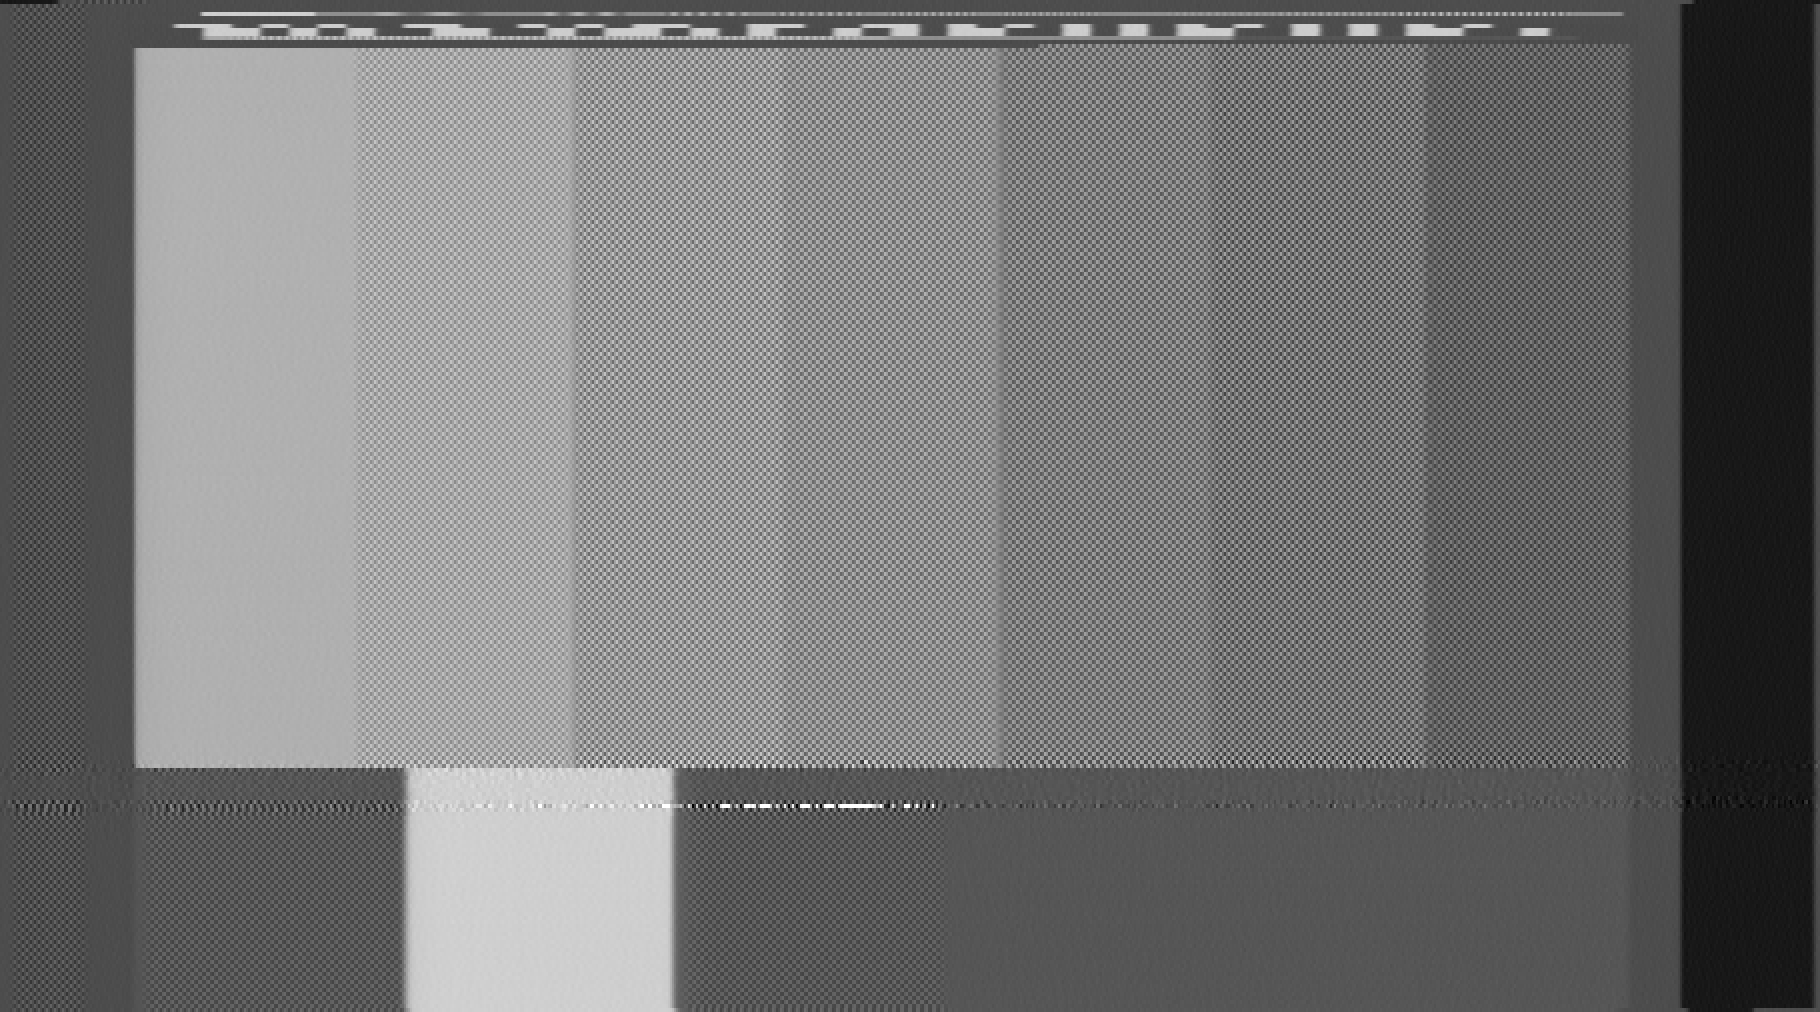

In [426]:
print(np.mean(finalsnr))
lines, sfactor = downscale(output, lineinfo3)

reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

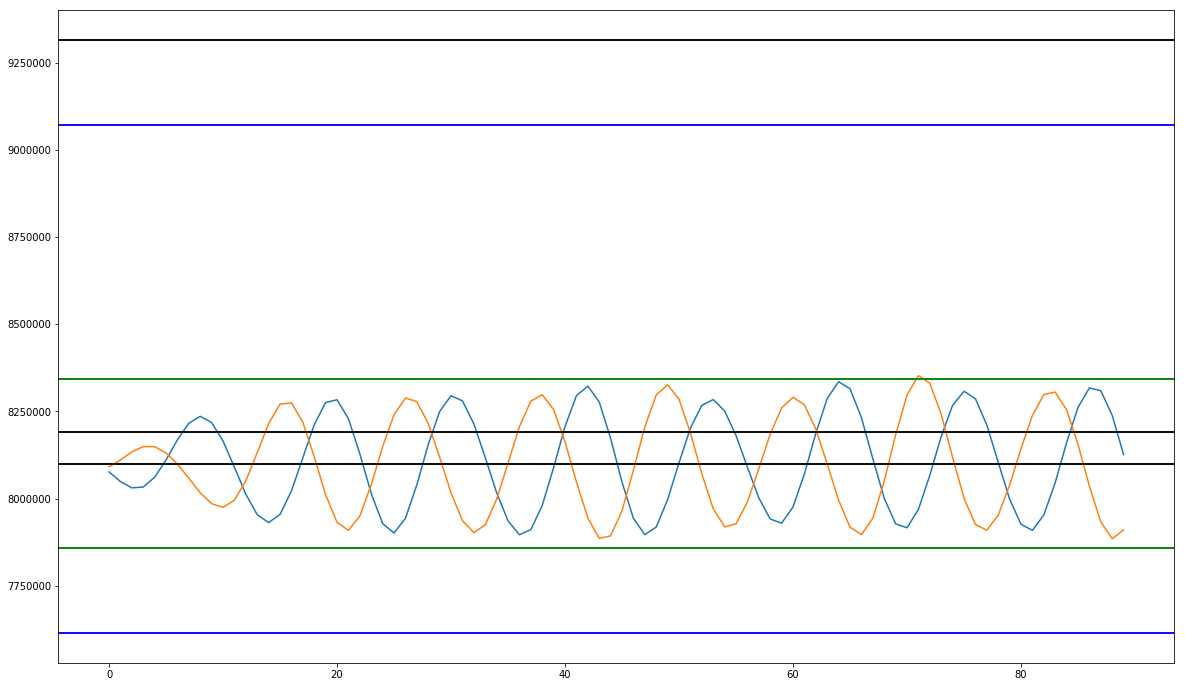

In [408]:
l = 27
x = output[int(lineinfo3[l][0]):int(lineinfo3[l+1][0])]
lineplot(x[20:110], filterset)

l = 28
y = output[int(lineinfo3[l][0]):int(lineinfo3[l+1][0])]
lineplot(y[20:110], filterset)


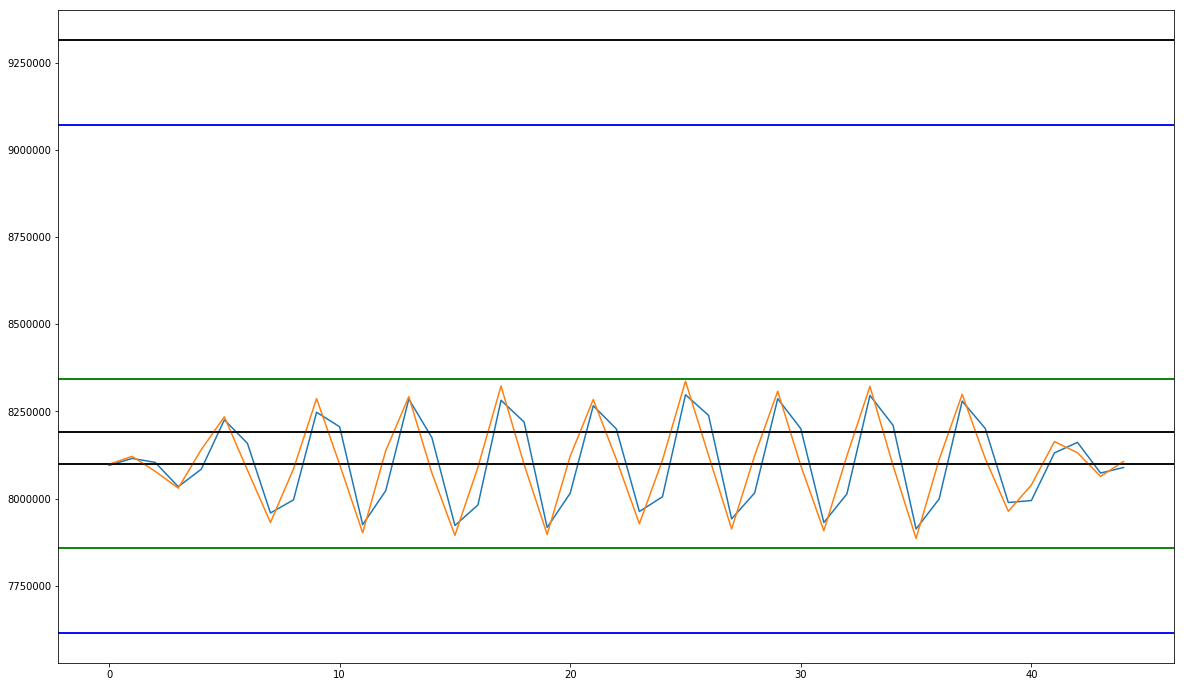

In [409]:
l = 27
x = lineso[l * 910:(l + 1) * 910]
lineplot(x[5:50], filterset)

l = 27
y = lines[l * 910:(l + 1) * 910]
lineplot(y[5:50], filterset)

(45.080027014062878, 35.112447749715066)

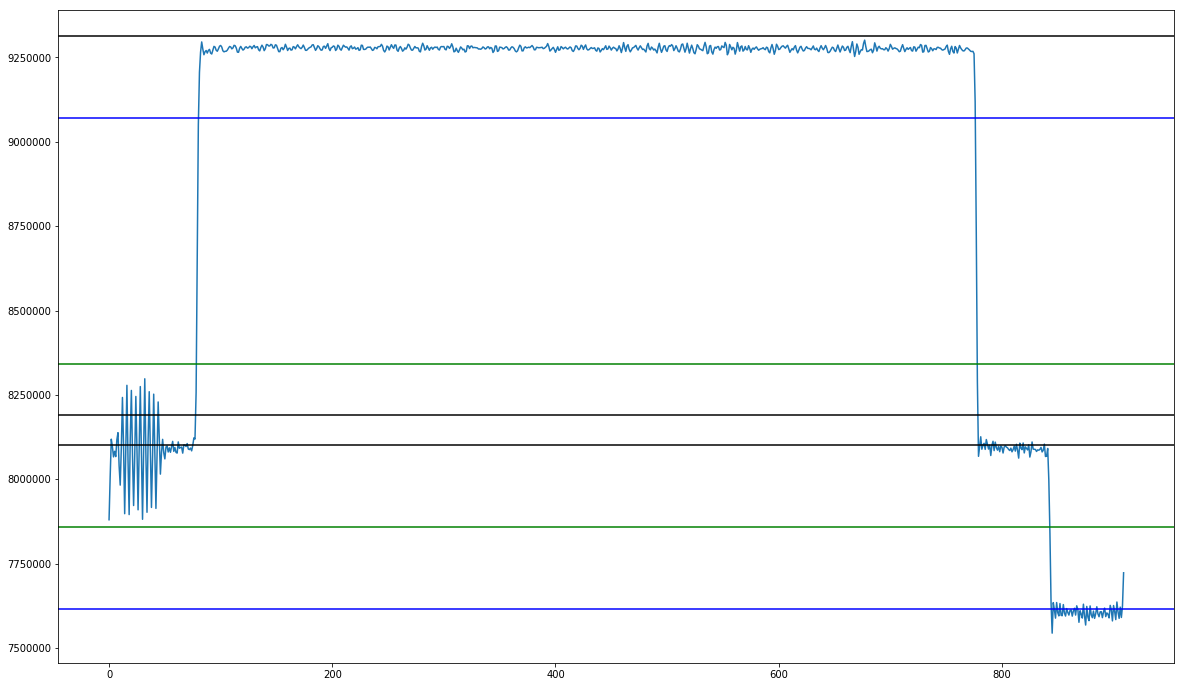

In [61]:
l = 1
x = lines[l * 910:(l + 1) * 910]
lineplot(x, filterset)
calcsnr(x[200:700]), calcsnr(x[850:])

In [62]:
snr = []
zcstart = []
zcend = []
zclen = []
for l in range(2, 250):
    preline = lines[(l * 910) - 20: (l * 910) + 20]
    _line = lines[(l * 910):(l + 2) * 910]
    
    x = lines[(910*l)+0:(910*l)+80]
    y = (x + lines[(910*l)+910:(910*l)+990]) / 2
    #plt.plot(y)

    zcstart.append(calczc(preline, 0, m20ire, 40) - 20)
    zcend.append(calczc(_line, 830, m20ire, 40))
    nextstart = calczc(_line, 900, m20ire, 40)
    zclen.append(nextstart - zcend[-1])
    snr.append(calcsnr(y[15:50]))
    print(l, calczc(preline, 0, m20ire, 40) - 20, calczc(_line, 830, m20ire, 40), calczc(_line, 900, m20ire, 40), calcsnr(y[15:50]))

2 0.0805832080497 842.860427005 909.850746834 40.1075826986
3 -0.149253166001 842.847391766 909.887333621 43.3194978334
4 -0.112666378753 842.761096314 909.883849088 41.9545766983
5 -0.116150911731 842.800224486 909.872527231 43.9049913763
6 -0.127472769063 842.778568666 909.937219462 41.7590875792
7 -0.0627805383294 842.787742189 909.894528978 36.9566969411
8 -0.105471021659 842.910504162 909.923849414 43.8605534011
9 -0.0761505859211 842.869424675 910.024761655 37.940036852
10 0.0247616552646 842.855020548 909.879673424 40.0829737051
11 -0.120326576213 842.753162521 910.013278818 42.7996418037
12 0.0132788180625 842.771407221 909.772877988 41.7411444344
13 -0.227122011923 842.806638544 909.867482287 38.5153419859
14 -0.132517712543 842.851041429 909.878833554 41.8054572892
15 -0.121166446014 842.740352631 909.767992423 39.6318106659
16 -0.232007576529 842.788309388 909.959515557 41.4724716013
17 -0.0404844431786 842.807360215 909.879363483 38.1410615583
18 -0.120636516683 842.8139285

204 0.0546714456993 842.870419527 909.883177544 42.0503951189
205 -0.116822456108 842.785649026 910.007901959 38.633170322
206 0.0079019594973 842.76552314 909.982697574 41.0399514219
207 -0.0173024263377 842.856450784 909.987169034 40.001413557
208 -0.0128309655823 842.788242349 909.904253938 41.6839928281
209 -0.095746062178 842.794264122 909.896187439 42.5350879347
210 -0.103812560961 842.783855943 910.028363498 40.3760537534
211 0.0283634979736 842.791803319 909.794632918 38.6556539534
212 -0.205367082444 842.876495368 909.915618566 41.7806777628
213 -0.0843814338397 842.854662638 909.962761677 42.9676890061
214 -0.0372383229385 842.796937299 909.846190734 41.1671817022
215 -0.153809265737 842.79843558 909.944067149 41.3072516805
216 -0.0559328512906 842.743517747 909.87452612 41.2238620344
217 -0.125473879614 842.813102272 909.850199137 40.1114414468
218 -0.149800862565 842.772007575 910.031036109 40.6795409071
219 0.0310361092518 842.835296167 909.910939539 43.3357683303
220 -0.0

In [63]:
np.mean(zclen), np.std(zclen)

(67.118102313399547, 0.084296795301364968)

In [64]:
np.std(zcstart), np.std(zcend), np.mean(snr)

(0.081186212859014034, 0.052871247228317909, 41.119441712221381)

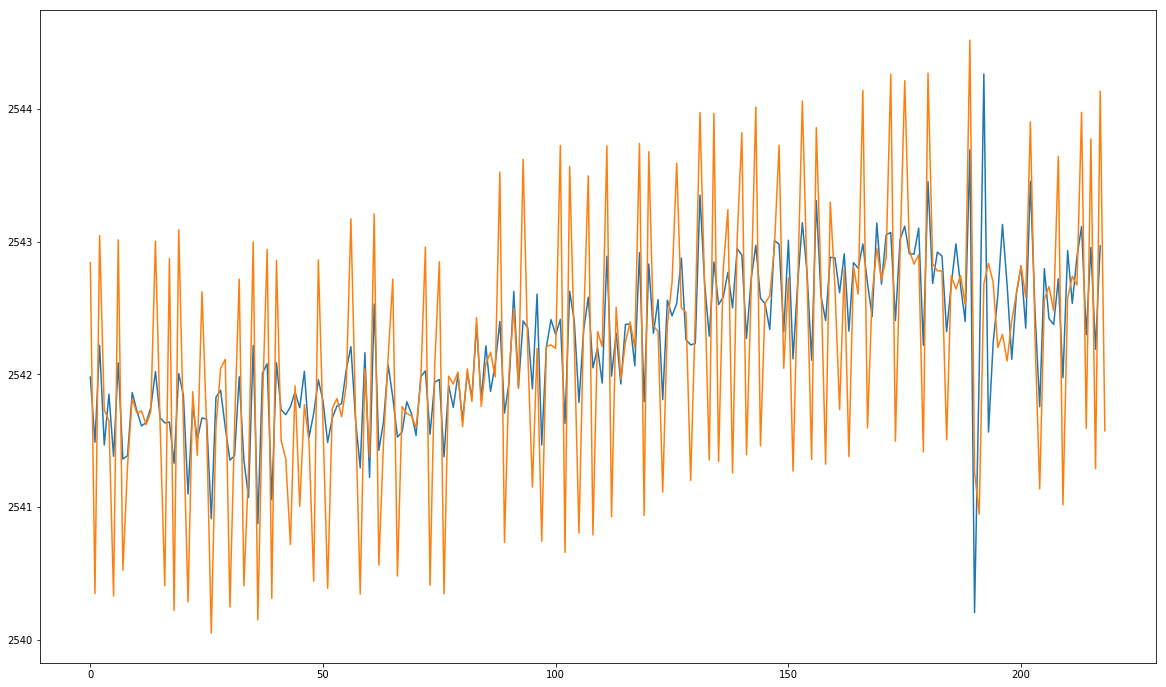

In [376]:
# tbc effectiveness check - line length.  lineinfo3 is pretty even
plt.plot(np.diff(lineinfo2[1:220]))
plt.plot(np.diff(lineinfo3[1:220]))